In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:
df_train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
df_test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
df_sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")

#datetime.strptime(datetime_str, '%y/%m/%d')
#train_df['date']= pd.to_datetime(train_df['date'])
#test_df['date']= pd.to_datetime(test_df['date'])
df_train.tail(10)

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
28790,28790,Intermediate,No,Intermediate,No,1.0,4.0,TBI + Cy +- Other,No,3.0,...,Permissive mismatched,Related,"N/A, Mel not given",4.0,No,1.0,No,6.0,1.0,12.940
28791,28791,Intermediate,No,Normal,No,1.0,4.0,TBI + Cy +- Other,No,3.0,...,Permissive mismatched,Related,"N/A, Mel not given",4.0,No,1.0,No,5.0,1.0,3.428
28792,28792,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,HvG non-permissive,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1.0,6.543
28793,28793,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,GvH non-permissive,NaN,MEL,8.0,No,2.0,No,10.0,1.0,5.802
28794,28794,N/A - pediatric,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1.0,6.279
28795,28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,...,Bi-directional non-permissive,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633
28796,28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,...,GvH non-permissive,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892
28797,28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,...,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157
28798,28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,3.0,...,Permissive mismatched,Related,MEL,4.0,No,1.0,No,5.0,0.0,52.351
28799,28799,N/A - pediatric,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,Yes,10.0,0.0,25.158


In [3]:
df_train["efs"].unique()

array([0., 1.])

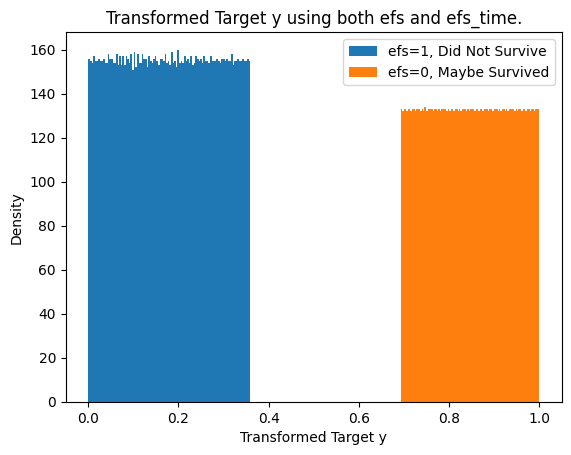

In [4]:
# Both targets efs and efs_time provide useful information. We will tranform these two targets into a single target to train our model with.
import matplotlib.pyplot as plt

df_train["y"] = df_train.efs_time.values
mx = df_train.loc[df_train.efs==1,"efs_time"].max()
mn = df_train.loc[df_train.efs==0,"efs_time"].min()
df_train.loc[df_train.efs==0,"y"] = df_train.loc[df_train.efs==0,"y"] + mx - mn
df_train.y = df_train.y.rank()
df_train.loc[df_train.efs==0,"y"] += len(df_train)//2
df_train.y = df_train.y / df_train.y.max()

plt.hist(df_train.loc[df_train.efs==1,"y"],bins=100,label="efs=1, Did Not Survive")
plt.hist(df_train.loc[df_train.efs==0,"y"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [5]:
df_train.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.875370
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.101458
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.726134
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.990463
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.711134
5,5,High,No,Poor,Yes,2.0,7.0,TBI + Cy +- Other,No,4.0,...,Related,"N/A, Mel not given",5.0,No,2.0,Yes,6.0,1.0,7.095,0.259074
6,6,Low,No,Poor,No,2.0,8.0,No TBI,No,6.0,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,0.0,46.464,0.895660
7,7,High,No,NaN,Not done,2.0,5.0,TBI + Cy +- Other,No,3.0,...,Related,"N/A, Mel not given",5.0,No,1.0,No,6.0,0.0,18.076,0.718380
8,8,Intermediate,No,Other,No,NaN,NaN,TBI + Cy +- Other,No,6.0,...,Related,"N/A, Mel not given",8.0,No,NaN,Yes,10.0,1.0,10.130,0.334884
9,9,Intermediate,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,9.0,1.0,5.434,0.152917


In [6]:
data_dictionary = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
df = pd.DataFrame(columns=['Column', 'Data Type' , 'Missing Count', 'Percentage'])

# Get columns with missing values
missing_columns = df_train.columns[df_train.isnull().any()].tolist()
for col in missing_columns:
    data_type = data_dictionary[data_dictionary['variable']==col]['type']
    missin_count = df_train[col].isnull().sum()
    total_count = len(df_train[col])
    pencentage = missin_count*100/total_count
    df.loc[len(df)] = [col,data_type,missin_count,pencentage] 

df.sort_values(by='Percentage',ascending=False)

,Column,Data Type,Missing Count,Percentage
27,tce_match,"32 Categorical Name: type, dtype: object",18996,65.958333
25,mrd_hct,"30 Categorical Name: type, dtype: object",16597,57.628472
21,cyto_score_detail,"25 Categorical Name: type, dtype: object",11923,41.399306
42,tce_div_match,"49 Categorical Name: type, dtype: object",11396,39.569444
15,tce_imm_match,"18 Categorical Name: type, dtype: object",11133,38.656250
2,cyto_score,"2 Categorical Name: type, dtype: object",8068,28.013889
13,hla_high_res_10,"16 Numerical Name: type, dtype: object",7163,24.871528
5,hla_high_res_8,"5 Numerical Name: type, dtype: object",5829,20.239583
11,hla_high_res_6,"14 Numerical Name: type, dtype: object",5284,18.347222
14,hla_match_dqb1_high,"17 Numerical Name: type, dtype: object",5199,18.052083


In [7]:
# Column	Data Type	                           Missing Count	Percentage
# tce_match	32 Categorical Name: type, dtype: object	18996	65.958333
# mrd_hct	30 Categorical Name: type, dtype: object	16597	57.628472
df_train = df_train.drop(['tce_match','mrd_hct'],axis=1)
df_test = df_test.drop(['tce_match','mrd_hct'],axis=1)

df = df[df['Column'] != 'tce_match']
df = df[df['Column'] != 'mrd_hct']

missing_columns.remove('tce_match')
missing_columns.remove('mrd_hct')

In [8]:
df_test.tail()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [9]:
# Apply imputation for missing value
df_train['hla_nmdp_6'] = (df_train['hla_match_a_low'].fillna(0) + df_train['hla_match_b_low'].fillna(0) + df_train['hla_match_drb1_high'].fillna(0))

df_train['hla_low_res_6'] = (df_train['hla_match_a_low'].fillna(0) + df_train['hla_match_b_low'].fillna(0) + df_train['hla_match_drb1_low'].fillna(0))

df_train['hla_high_res_6'] = (df_train['hla_match_a_high'].fillna(0) + df_train['hla_match_b_high'].fillna(0) + df_train['hla_match_drb1_high'].fillna(0))

df_train['hla_low_res_8'] = (df_train['hla_match_a_low'].fillna(0) + df_train['hla_match_b_low'].fillna(0) + df_train['hla_match_c_low'].fillna(0)
                             + df_train['hla_match_drb1_low'].fillna(0))

df_train['hla_high_res_8'] = (df_train['hla_match_a_high'].fillna(0) + df_train['hla_match_b_high'].fillna(0) + df_train['hla_match_c_high'].fillna(0)
                             + df_train['hla_match_drb1_high'].fillna(0))  

df_train['hla_low_res_10'] = (df_train['hla_match_a_low'].fillna(0) + df_train['hla_match_b_low'].fillna(0) + df_train['hla_match_c_low'].fillna(0)
                             + df_train['hla_match_drb1_low'].fillna(0) + df_train['hla_match_dqb1_low'].fillna(0) ) 

df_train['hla_high_res_10'] = (df_train['hla_match_a_high'].fillna(0) + df_train['hla_match_b_high'].fillna(0) + df_train['hla_match_c_high'].fillna(0)
                             + df_train['hla_match_drb1_high'].fillna(0) + df_train['hla_match_dqb1_high'].fillna(0)) 
#
df_test['hla_nmdp_6'] = (df_test['hla_match_a_low'].fillna(0) + df_test['hla_match_b_low'].fillna(0) + df_test['hla_match_drb1_high'].fillna(0))

df_test['hla_low_res_6'] = (df_test['hla_match_a_low'].fillna(0) + df_test['hla_match_b_low'].fillna(0) + df_test['hla_match_drb1_low'].fillna(0))

df_test['hla_high_res_6'] = (df_test['hla_match_a_high'].fillna(0) + df_test['hla_match_b_high'].fillna(0) + df_test['hla_match_drb1_high'].fillna(0))

df_test['hla_low_res_8'] = (df_test['hla_match_a_low'].fillna(0) + df_test['hla_match_b_low'].fillna(0) + df_test['hla_match_c_low'].fillna(0)
                             + df_test['hla_match_drb1_low'].fillna(0))

df_test['hla_high_res_8'] = (df_test['hla_match_a_high'].fillna(0) + df_test['hla_match_b_high'].fillna(0) + df_test['hla_match_c_high'].fillna(0)
                             + df_test['hla_match_drb1_high'].fillna(0))  

df_test['hla_low_res_10'] = (df_test['hla_match_a_low'].fillna(0) + df_test['hla_match_b_low'].fillna(0) + df_test['hla_match_c_low'].fillna(0)
                             + df_test['hla_match_drb1_low'].fillna(0) + df_test['hla_match_dqb1_low'].fillna(0) ) 

df_test['hla_high_res_10'] = (df_test['hla_match_a_high'].fillna(0) + df_test['hla_match_b_high'].fillna(0) + df_test['hla_match_c_high'].fillna(0)
                             + df_test['hla_match_drb1_high'].fillna(0) + df_test['hla_match_dqb1_high'].fillna(0)) 

In [10]:
# remove columns
df_train = df_train.drop(['hla_match_a_low','hla_match_b_low','hla_match_c_low','hla_match_a_high','hla_match_b_high','hla_match_c_high',
                        'hla_match_drb1_high','hla_match_drb1_low','hla_match_dqb1_high','hla_match_dqb1_low'],axis=1)

df_test = df_test.drop(['hla_match_a_low','hla_match_b_low','hla_match_c_low','hla_match_a_high','hla_match_b_high','hla_match_c_high',
                        'hla_match_drb1_high','hla_match_drb1_low','hla_match_dqb1_high','hla_match_dqb1_low'],axis=1)

In [11]:
missing_columns.remove('hla_match_a_low')
missing_columns.remove('hla_match_b_low')
missing_columns.remove('hla_match_c_low')
missing_columns.remove('hla_match_a_high')
missing_columns.remove('hla_match_b_high')
missing_columns.remove('hla_match_c_high')
missing_columns.remove('hla_match_drb1_high')
missing_columns.remove('hla_match_drb1_low')
missing_columns.remove('hla_match_dqb1_high')
missing_columns.remove('hla_match_dqb1_low')

missing_cat_cols = df_train[missing_columns].select_dtypes(exclude='number').columns
missing_num_cols = df_train[missing_columns].select_dtypes(include='number').columns

In [12]:
# Applying median imputation to all numerical columns
for num_col in missing_num_cols:
    df_train[num_col] = df_train[num_col].fillna(-1)
    df_test[num_col] = df_test[num_col].fillna(-1)
# Applying mode imputation to all categorical columns
for cal_col in missing_cat_cols:
    df_train[cal_col] = df_train[cal_col].fillna('Unknown')
    df_test[cal_col] = df_test[cal_col].fillna('Unknown')
# Convert all numerical colums data type to int
s = df_train.select_dtypes(include='number').columns.delete(len(df_train.select_dtypes(include='number').columns)-1)
for num_col in s:
    df_train[num_col] = df_train[num_col].astype(int)

for num_col in df_test.select_dtypes(include='number').columns:
    df_test[num_col] = df_test[num_col].astype(int)

In [13]:
# Create Readable mapping for categorical columns
## Mapping for Refined disease risk index
map_dri_score={
    'Very high': 'Very High',
    'High':'High',
    'Intermediate': 'Intermediate',
    'Low':'Low',
    'N/A - non-malignant indication':'NA Non Malignant Indication',
    'N/A - pediatric':'NA Pediatric',
    'N/A - disease not classifiable':'NA Disease Not Classifiable',
    'High - TED AML case <missing cytogenetics': 'High TED AML Case',
    'Intermediate - TED AML case <missing cytogenetics': 'Intermediate TED AML Case',
    'TBD cytogenetics': 'TBD Cytogenetics',
    'Missing disease status': 'Unknown',
    np.NaN:'Unknown', 
}

## Mapping for Donor/recipient CMV serostatus
map_cmv_status = {
    '+/+': 'Positive Positive',
    '-/+': 'Negative Positive',
    '-/-': 'Negative Negative',
    '+/-': 'Positive Negative',
    np.NaN:'Unknown'
}

## Mapping for TBI
map_tbi_status={
    'No TBI':'No TBI',
    'TBI +- Other, >cGy': 'TBI Positive Negative Other Greater Cyclophosphamide',
    'TBI +- Other: >cGy': 'TBI Positive Negative Other Greater Cyclophosphamide',
    'TBI + Cy +- Other': 'TBI Positive Cyclophosphamide Positive Negative Other',
    'TBI +- Other, <=cGy': 'TBI Positive Negative Other Less Equal Cyclophosphamide',
    'TBI +- Other, unknown dose': 'TBI Positive Negative Other Unknown Does',
    'TBI +- Other, -cGy, fractionated': 'TBI Positive Negative Other Negative Cyclophosphamide Fractionated',
    'TBI +- Other, -cGy, single': 'TBI Positive Negative Other Negative Cyclophosphamide Single',
    'TBI +- Other, -cGy, unknown dose': 'TBI Positive Negative Other Negative Cyclophosphamide Unknown Does',
}

## Mapping for tce_imm_match
map_tce_imm_match={
    np.NaN:'Unknown',
    'P/P':'PP',
    'G/B':'GB',
    'H/B':'HB',
    'G/G':'GG',
    'P/H':'PH',
    'P/B':'PB',
    'H/H':'HH',
    'P/G':'PG'
}

## Mapping for gvhd_proph
map_gvhd_proph={
    'FKalone':'FK Alone',
    'Other GVHD Prophylaxis':'Other GVHD Prophylaxis',
    'Cyclophosphamide alone':'Cyclophosphamide Alone',
    'FK+ MMF +- others': 'FK Positive MMF Positive Negative Others',
    'TDEPLETION +- other': 'TDEPLETION Positive Negative Others',
    'CSA + MMF +- others(not FK)': 'CSA Positive MMF Positive Negative Others Not FK',
    'CSA + MTX +- others(not MMF,FK)': 'CSA Positive MTX Positive Negative Others Not MMF And FK',
    'FK+ MTX +- others(not MMF)': 'FK Positive MTX Positive Negative Others Not MMF',
    'Cyclophosphamide +- others': 'Cyclophosphamide Positive Negative Others',
    'CSA alone': 'CSA Alone',     
    'TDEPLETION alone': 'DEPLETION Alone',
    'No GvHD Prophylaxis': 'No GVHD Prophylaxis',
    'CDselect alone':'CDselect Alone',
    'CDselect +- other': 'CD Select Positive Negative Others',
    'Parent Q = yes, but no agent': 'Parent Q Equal Yes But No Agent',
    'FK+- others(not MMF,MTX)': 'FK Positive Negative Others Not MMF And MTX',
    'CSA +- others(not FK,MMF,MTX)':'CSA Positive Negative Others Not FK And MMF And MTX',
    np.NaN:'Unknown'
}

## Mapping for sex_match
map_sex_match={
    'M-F':'Male Female',
    'F-F':'Female Female', 
    'F-M':'Female Male', 
    'M-M':'Male Male',
    np.NaN:'Unknown'
}

## Mapping for donor_related
map_donor_related={
    'Unrelated':'Unrelated', 
    'Related':'Related',
    'Multiple donor (non-UCB)':'Multiple Donor Non UCB',
    np.NaN:'Unknown'
}

## Mapping for tce_div_match
map_tce_div_match={
    'Permissive mismatched':'Permissive Mismatched', 
    'GvH non-permissive':'GVH Non Permissive',
    'HvG non-permissive':'HVG Non Permissive', 
    'Bi-directional non-permissive':'Bi Directional Non Permissive',
    np.NaN:'Unknown'
}

## Mapping for melphalan_dose
map_melphalan_dose={
    'N/A, Mel not given':'No Dose', 
    'MEL':'Given',
    np.NaN:'Unknown'
}

## Mapping for race_group
map_race_group = {
    'More than one race':'More Than One Race',
    'Asian':'Asian',
    'White':'White',
    'American Indian or Alaska Native':'American Indian Or Alaska Native',
    'Native Hawaiian or other Pacific Islander':'Native Hawaiian Or Other Pacific Islander',
    'Black or African-American':'Black Or African American'
}

In [14]:
# Apply Mapping to Training and Test dataset
df_train['dri_score'] = df_train['dri_score'].replace(map_dri_score)
df_train['cmv_status'] = df_train['cmv_status'].replace(map_cmv_status)
df_train['tbi_status'] = df_train['tbi_status'].replace(map_tbi_status)
df_train['tce_imm_match'] = df_train['tce_imm_match'].replace(map_tce_imm_match)
df_train['gvhd_proph'] = df_train['gvhd_proph'].replace(map_gvhd_proph)
df_train['sex_match'] = df_train['sex_match'].replace(map_sex_match)
df_train['donor_related'] = df_train['donor_related'].replace(map_donor_related)
df_train['tce_div_match'] = df_train['tce_div_match'].replace(map_tce_div_match)
df_train['melphalan_dose'] = df_train['melphalan_dose'].replace(map_melphalan_dose)
df_train['race_group'] = df_train['race_group'].replace(map_race_group)
df_test['dri_score'] = df_test['dri_score'].replace(map_dri_score)
df_test['cmv_status'] = df_test['cmv_status'].replace(map_cmv_status)
df_test['tbi_status'] = df_test['tbi_status'].replace(map_tbi_status)
df_test['tce_imm_match'] = df_test['tce_imm_match'].replace(map_tce_imm_match)
df_test['gvhd_proph'] = df_test['gvhd_proph'].replace(map_gvhd_proph)
df_test['sex_match'] = df_test['sex_match'].replace(map_sex_match)
df_test['donor_related'] = df_test['donor_related'].replace(map_donor_related)
df_test['tce_div_match'] = df_test['tce_div_match'].replace(map_tce_div_match)
df_test['melphalan_dose'] = df_test['melphalan_dose'].replace(map_melphalan_dose)
df_test['race_group'] = df_test['race_group'].replace(map_race_group)

In [15]:
df_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,NA Non Malignant Indication,No,Unknown,No,6,No TBI,No,6,Bone marrow,...,Unknown,Unrelated,No Dose,8,No,No,10,0,42,0.875370
1,1,Intermediate,No,Intermediate,No,8,TBI Positive Negative Other Greater Cyclophosp...,No,6,Peripheral blood,...,Permissive Mismatched,Related,No Dose,8,No,Yes,10,1,4,0.101458
2,2,NA Non Malignant Indication,No,Unknown,No,8,No TBI,No,6,Bone marrow,...,Permissive Mismatched,Related,No Dose,8,No,No,10,0,19,0.726134
3,3,High,No,Intermediate,No,8,No TBI,No,6,Bone marrow,...,Permissive Mismatched,Unrelated,No Dose,8,No,No,10,0,102,0.990463
4,4,High,No,Unknown,No,8,No TBI,No,6,Peripheral blood,...,Permissive Mismatched,Related,Given,8,No,No,10,0,16,0.711134


In [16]:
# Apply LabelEncoder to categorical columns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

cat_cols = df_train.select_dtypes(exclude='number').columns
num_cols = df_train.select_dtypes(include='number').columns

lbl_encoder = LabelEncoder()
for col in cat_cols:
    df_train[col]=lbl_encoder.fit_transform(df_train[col]).astype(int)
    df_test[col]=lbl_encoder.transform(df_test[col]).astype(int)
df_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,6,0,7,0,6,0,0,6,0,...,4,3,1,8,0,0,10,0,42,0.875370
1,1,2,0,1,0,8,2,0,6,1,...,3,1,1,8,0,3,10,1,4,0.101458
2,2,6,0,7,0,8,0,0,6,0,...,3,1,1,8,0,0,10,0,19,0.726134
3,3,0,0,1,0,8,0,0,6,0,...,3,3,1,8,0,0,10,0,102,0.990463
4,4,0,0,7,0,8,0,0,6,1,...,3,1,0,8,0,0,10,0,16,0.711134


In [17]:
df_train.columns[1:46]

Index(['dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6',
       'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe',
       'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10',
       'tce_imm_match', 'hla_nmdp_6', 'rituximab', 'prod_type',
       'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct',
       'obesity', 'in_vivo_tcd', 'hepatic_severe', 'donor_age', 'prior_tumor',
       'peptic_ulcer', 'age_at_hct', 'gvhd_proph', 'rheum_issue', 'sex_match',
       'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild',
       'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8',
       'cardiac', 'pulm_moderate', 'hla_low_res_10'],
      dtype='object')

In [18]:
#from sklearn.ensemble import RandomForestRegressor

#m = RandomForestRegressor(200, min_samples_leaf=5)
#m.fit(df_train[df_train.columns[1:46]], df_train["y"]);

from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor(max_leaf_nodes=10)
m.fit(df_train[df_train.columns[1:46]], df_train["efs"]);   #.45

In [19]:
import math
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

m_rmse(m, df_train[df_train.columns[1:46]], df_train["efs"])

0.466495

In [20]:
# from sklearn.ensemble import RandomForestClassifier

# m = RandomForestClassifier(200, min_samples_leaf=3)
# m.fit(df_train[df_train.columns[1:46]], df_train["efs"]);

In [21]:
# m_rmse(m, df_train[df_train.columns[1:46]], df_train["efs"])

In [22]:
#Predict the response for test dataset
y_pred = m.predict(df_test[df_test.columns[1:46]])
y_pred

array([0.21215285, 0.58622973, 0.21215285])

In [23]:
for i in df_sub.index:
    df_sub["prediction"].at[i] = y_pred[i]
    
df_sub.head()

,ID,prediction
0,28800,0.212153
1,28801,0.586230
2,28802,0.212153


In [24]:
df_sub.to_csv("/kaggle/working/submission.csv", index=False)